In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Ustawienie losowego seeda dla powtarzalności
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Wczytanie danych
df = pd.read_csv('../data/final_data.csv', delimiter=';')
print("Rozmiary df:", df.shape)
print("Kilka pierwszych wierszy:")
display(df.head())


Rozmiary df: (5826, 192)
Kilka pierwszych wierszy:


,id,latitude,longitude,accommodates,bedrooms,beds,instant_bookable,bathrooms_num,amenity_Wifi,amenity_Kitchen,...,neighbourhood_group_cleansed_Les Corts,neighbourhood_group_cleansed_Nou Barris,neighbourhood_group_cleansed_Sant Andreu,neighbourhood_group_cleansed_Sant Martí,neighbourhood_group_cleansed_Sants-Montjuïc,neighbourhood_group_cleansed_Sarrià-Sant Gervasi,bathroom_type_private,bathroom_type_shared,bathroom_type_unknown,price
0,16989407,41.409920,2.157330,2,1.0,2.0,0,1.5,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,150.0
1,34133454,41.397630,2.159340,3,1.0,1.0,1,1.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,999.0
2,"1,04185E+18",41.394798,2.165613,2,1.0,1.0,1,1.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,200.0
3,"6,95612E+17",41.399490,2.202610,2,1.0,1.0,0,1.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,90.0
4,847195,41.385080,2.155270,4,2.0,3.0,0,2.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,90.0


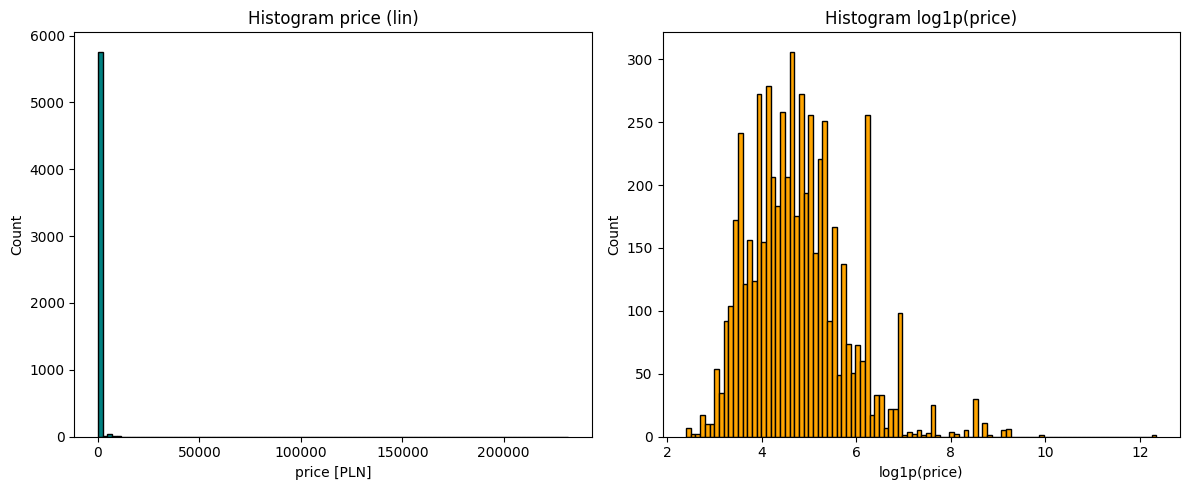

Price > 500 PLN: 7.64% obserwacji
Price > 1000 PLN: 1.91% obserwacji
Price > 2000 PLN: 1.15% obserwacji
Price > 5000 PLN: 0.43% obserwacji


In [62]:
# Histogram ceny w skali liniowej i logarytmicznej
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['price'], bins=100, color='teal', edgecolor='black')
plt.title('Histogram price (lin)')
plt.xlabel('price [PLN]')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df['price']), bins=100, color='orange', edgecolor='black')
plt.title('Histogram log1p(price)')
plt.xlabel('log1p(price)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Proporcja ofert powyżej różnych progów
for threshold in [500, 1000, 2000, 5000]:
    pct = (df['price'] > threshold).mean() * 100
    print(f"Price > {threshold} PLN: {pct:.2f}% obserwacji")


In [63]:
premium_threshold = 1000
df['is_premium'] = (df['price'] > premium_threshold).astype(int)
print("Liczba premium ofert (>1000 PLN):", df['is_premium'].sum(), "/", len(df),
      f"  (udział {df['is_premium'].mean()*100:.2f}%)")


Liczba premium ofert (>1000 PLN): 111 / 5826   (udział 1.91%)


In [64]:
price_log = np.log1p(df['price'])

corrs = []
for col in df.columns:
    if col in ['id', 'price', 'is_premium']:
        continue
    if pd.api.types.is_numeric_dtype(df[col]):
        c = np.corrcoef(df[col], price_log, rowvar=False)[0, 1]
        corrs.append((col, abs(c)))

corrs_sorted = sorted(corrs, key=lambda x: x[1], reverse=True)

print("Top 20 cech o najwyższej korelacji z log1p(price):")
for col, cval in corrs_sorted[:20]:
    print(f"{col:<40} {cval:.3f}")

# Wybór Top 50
top_k = [col for col, _ in corrs_sorted[:50]]
print(f"\nWybrano {len(top_k)} cech jako Top 50")

X = df[top_k].copy()
y = price_log.copy()

print("\nKształt X:", X.shape)
print("Kształt y:", y.shape)


Top 20 cech o najwyższej korelacji z log1p(price):
accommodates                             0.530
property_type_Private room in rental unit 0.507
room_type_Private room                   0.468
room_type_Entire home/apt                0.449
property_type_Entire rental unit         0.404
bedrooms                                 0.379
bathroom_type_shared                     0.373
bathroom_type_unknown                    0.324
amenity_Dishwasher                       0.317
amenity_Hair dryer                       0.306
instant_bookable                         0.292
amenity_Air conditioning                 0.288
amenity_Lock on bedroom door             0.282
amenity_Crib                             0.274
beds                                     0.261
amenity_Oven                             0.250
amenity_Hot water kettle                 0.229
amenity_Toaster                          0.226
amenity_Microwave                        0.220
amenity_Coffee maker                     0.219

Wybrano

In [65]:
# Przykład dodatkowej cechy: price_per_person (do analizy, nie do treningu)
df['price_per_person'] = df['price'] / df['accommodates']

# Jeżeli chcesz log1p przekształcić pewne cechy:
for col in ['number_of_reviews', 'reviews_per_month']:
    if col in df.columns:
        df[f'log1p_{col}'] = np.log1p(df[col])

# Jeśli coś dodasz, pamiętaj dodać do top_k, np.:
# top_k.append('price_per_person')
# top_k.append('log1p_number_of_reviews')
# Po edycji ponownie:
# X = df[top_k].copy()


In [66]:
# 1) Podział 80/20 (trainval/test)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X.values, y.values, test_size=0.20, random_state=42, shuffle=True
)

# 2) Podział 75/25 w trainval (czyli 60/20/20 całego zbioru)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, shuffle=True
)

print(f"Rozmiary zbiorów: Train={X_train.shape[0]}, Val={X_val.shape[0]}, Test={X_test.shape[0]}")

# 3) Skalowanie – uczymy na X_train, transformujemy Val i Test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# 4) Konwersja na tensory
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)

X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

# 5) DataLoadery
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t,   y_val_t),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=batch_size, shuffle=False)

# Sanity check
xb, yb = next(iter(train_loader))
print("Przykładowy batch: X =", xb.shape, ", y =", yb.shape)


Rozmiary zbiorów: Train=3495, Val=1165, Test=1166
Przykładowy batch: X = torch.Size([32, 50]) , y = torch.Size([32, 1])


In [67]:
class MLP_50(nn.Module):
    def __init__(self, input_dim=50):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# Krótka weryfikacja
model = MLP_50(input_dim=X_train_t.shape[1]).to(torch.device("cpu"))
print(model)


MLP_50(
  (net): Sequential(
    (0): Linear(in_features=50, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [68]:
# train_one_epoch: trenuje model jedną epokę; wywołuje scheduler.step() raz per batch
def train_one_epoch(model, loader, optimizer, loss_fn, scheduler, device):
    model.train()
    running_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        # scheduler.step() **tylko** tutaj – raz na batch
        scheduler.step()
        running_loss += loss.item() * xb.size(0)
    return running_loss / len(loader.dataset)

# evaluate: oblicza średnią stratę (log), R², MAE i RMSE w PLN
@torch.no_grad()
def evaluate(model, loader, device, train_on_log=True):
    model.eval()
    all_preds = []
    all_trues = []
    total_loss = 0.0

    loss_eval = nn.MSELoss() if train_on_log else nn.SmoothL1Loss(beta=1.0)

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = loss_eval(preds, yb)
        total_loss += loss.item() * xb.size(0)
        all_preds.append(preds.cpu().numpy().flatten())
        all_trues.append(yb.cpu().numpy().flatten())

    avg_loss = total_loss / len(loader.dataset)
    all_preds = np.concatenate(all_preds)
    all_trues = np.concatenate(all_trues)

    if train_on_log:
        preds_exp = np.expm1(all_preds)
        trues_exp = np.expm1(all_trues)
    else:
        preds_exp = all_preds
        trues_exp = all_trues

    r2   = r2_score(trues_exp, preds_exp)
    mae  = mean_absolute_error(trues_exp, preds_exp)
    rmse = np.sqrt(mean_squared_error(trues_exp, preds_exp))
    return avg_loss, r2, mae, rmse

# Sprawdzenie definicji
print("Funkcje train_one_epoch i evaluate zdefiniowane poprawnie.")


Funkcje train_one_epoch i evaluate zdefiniowane poprawnie.


In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Używane urządzenie:", device)

# 1) Model
model = MLP_50(input_dim=X_train_t.shape[1]).to(device)

# 2) Funkcja straty (na log1p(price))
loss_fn = nn.MSELoss()

# 3) Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# 4) Scheduler OneCycleLR – DOGADAMY 'epochs' z num_epochs
num_epochs = 200
steps_per_epoch = len(train_loader)
print("Steps per epoch:", steps_per_epoch)
print("Całkowita liczba kroków (na wszystkie epoki):", steps_per_epoch * num_epochs)

scheduler = OneCycleLR(
    optimizer,
    max_lr=5e-4,         # zamiast 1e-3 spróbuj 5e-4
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    pct_start=0.3,
    div_factor=25.0,
    final_div_factor=1e4
)



Używane urządzenie: cuda
Steps per epoch: 110
Całkowita liczba kroków (na wszystkie epoki): 22000


In [70]:
best_val_r2 = -np.inf
epochs_no_improve = 0
patience = 20  # przerwij, jeśli przez 10 epok brak poprawy R²

train_losses_history = []
val_losses_history   = []
val_r2_history       = []

for epoch in range(1, num_epochs + 1):
    # -- Trening jednej epoki --
    train_loss_epoch = train_one_epoch(model, train_loader, optimizer, loss_fn, scheduler, device)
    train_losses_history.append(train_loss_epoch)

    # -- Walidacja --
    val_loss_epoch, val_r2_epoch, val_mae_epoch, val_rmse_epoch = evaluate(model, val_loader, device, train_on_log=True)
    val_losses_history.append(val_loss_epoch)
    val_r2_history.append(val_r2_epoch)

    print(f"Epoka {epoch:03d} | "
          f"Train MSE(log) = {train_loss_epoch:.4f} | "
          f"Val MSE(log)   = {val_loss_epoch:.4f} | "
          f"Val R²         = {val_r2_epoch:.4f} | "
          f"Val MAE        = {val_mae_epoch:.2f} PLN | "
          f"Val RMSE       = {val_rmse_epoch:.2f} PLN")

    # -- Early stopping wg najlepszego R² --
    if val_r2_epoch > best_val_r2:
        best_val_r2 = val_r2_epoch
        torch.save(model.state_dict(), "best_model_50.pth")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"\nBrak poprawy R² przez {patience} epok → early stopping.")
        break

# Po zakończeniu treningu ładujemy najlepszy model
model.load_state_dict(torch.load("best_model_50.pth", map_location=device))
print("\n[INFO] Trening zakończony. Najlepszy model wczytany.")


Epoka 001 | Train MSE(log) = 22.8525 | Val MSE(log)   = 23.0545 | Val R²         = -0.1224 | Val MAE        = 238.25 PLN | Val RMSE       = 721.37 PLN
Epoka 002 | Train MSE(log) = 22.6528 | Val MSE(log)   = 22.6455 | Val R²         = -0.1223 | Val MAE        = 238.23 PLN | Val RMSE       = 721.34 PLN
Epoka 003 | Train MSE(log) = 22.5481 | Val MSE(log)   = 22.6174 | Val R²         = -0.1222 | Val MAE        = 238.22 PLN | Val RMSE       = 721.33 PLN
Epoka 004 | Train MSE(log) = 22.3900 | Val MSE(log)   = 22.6408 | Val R²         = -0.1222 | Val MAE        = 238.22 PLN | Val RMSE       = 721.31 PLN
Epoka 005 | Train MSE(log) = 22.1688 | Val MSE(log)   = 22.7171 | Val R²         = -0.1221 | Val MAE        = 238.22 PLN | Val RMSE       = 721.28 PLN
Epoka 006 | Train MSE(log) = 21.9684 | Val MSE(log)   = 21.9472 | Val R²         = -0.1219 | Val MAE        = 238.12 PLN | Val RMSE       = 721.23 PLN
Epoka 007 | Train MSE(log) = 21.9044 | Val MSE(log)   = 22.2664 | Val R²         = -0.1219 | V

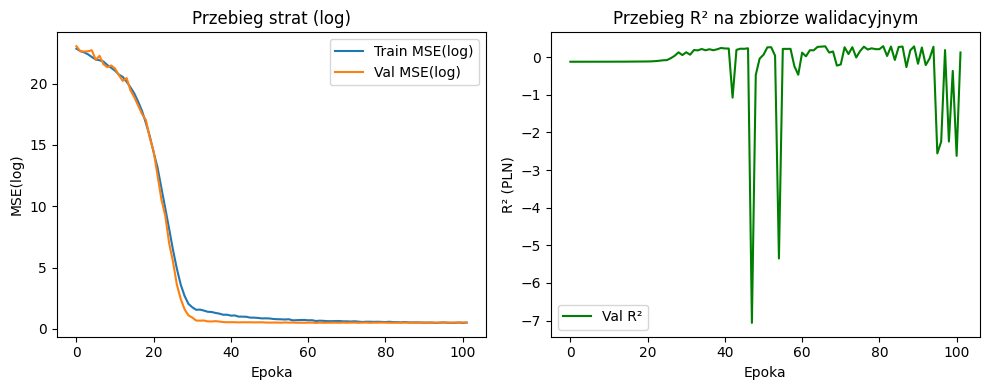

In [71]:
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.plot(train_losses_history, label="Train MSE(log)")
plt.plot(val_losses_history,   label="Val MSE(log)")
plt.xlabel("Epoka")
plt.ylabel("MSE(log)")
plt.legend()
plt.title("Przebieg strat (log)")

plt.subplot(1, 2, 2)
plt.plot(val_r2_history, label="Val R²", color="green")
plt.xlabel("Epoka")
plt.ylabel("R² (PLN)")
plt.legend()
plt.title("Przebieg R² na zbiorze walidacyjnym")

plt.tight_layout()
plt.show()



=== Wyniki na zbiorze testowym ===
Test MSE(log) = 0.4242
Test R²       = -1.8200
Test MAE      = 142.89 PLN
Test RMSE     = 952.67 PLN


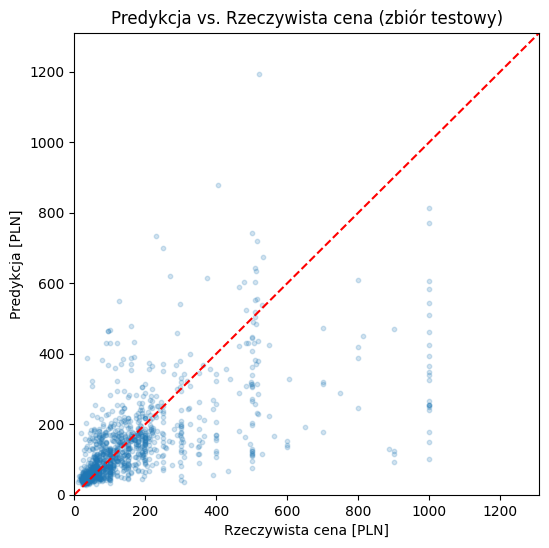

In [72]:
test_loss, test_r2, test_mae, test_rmse = evaluate(model, test_loader, device, train_on_log=True)
print("\n=== Wyniki na zbiorze testowym ===")
print(f"Test MSE(log) = {test_loss:.4f}")
print(f"Test R²       = {test_r2:.4f}")
print(f"Test MAE      = {test_mae:.2f} PLN")
print(f"Test RMSE     = {test_rmse:.2f} PLN")

# Scatter plot predykcji vs. y_true (ograniczone do 99 percentyla)
model.eval()
preds_list = []
trues_list = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).cpu().numpy().flatten()
        trues = yb.cpu().numpy().flatten()
        preds_list.append(preds)
        trues_list.append(trues)

preds_log = np.concatenate(preds_list)
trues_log = np.concatenate(trues_list)
preds_pln = np.expm1(preds_log)
trues_pln = np.expm1(trues_log)

lim = np.percentile(np.concatenate([trues_pln, preds_pln]), 99)

plt.figure(figsize=(6,6))
plt.scatter(trues_pln, preds_pln, alpha=0.2, s=10)
plt.plot([0, lim], [0, lim], color="red", ls="--")
plt.xlim(0, lim)
plt.ylim(0, lim)
plt.xlabel("Rzeczywista cena [PLN]")
plt.ylabel("Predykcja [PLN]")
plt.title("Predykcja vs. Rzeczywista cena (zbiór testowy)")
plt.show()


In [73]:
# Zebranie predykcji i y_true w log-skalach
model.eval()
all_preds = []
all_trues = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).cpu().numpy().flatten()
        trues = yb.cpu().numpy().flatten()
        all_preds.append(preds)
        all_trues.append(trues)

all_preds = np.concatenate(all_preds)
all_trues = np.concatenate(all_trues)

# Sprawdzenie nan/inf w log
print("Predykcje (log): NaN =", np.isnan(all_preds).sum(), ", inf =", np.isinf(all_preds).sum())
print("Rzeczywiste y (log): NaN =", np.isnan(all_trues).sum(), ", inf =", np.isinf(all_trues).sum())

# Odwrócenie log → skala PLN
preds_pln = np.expm1(all_preds)
trues_pln = np.expm1(all_trues)
print("Predykcje (PLN): NaN =", np.isnan(preds_pln).sum(), ", inf =", np.isinf(preds_pln).sum())
print("Rzeczywiste y (PLN): NaN =", np.isnan(trues_pln).sum(), ", inf =", np.isinf(trues_pln).sum())

# Zakres wartości
print("Zakres predykcji (log): min =", np.nanmin(all_preds), 
      ", max =", np.nanmax(all_preds))
print("Zakres predykcji (PLN): min =", np.nanmin(preds_pln), 
      ", max =", np.nanmax(preds_pln))


Predykcje (log): NaN = 0 , inf = 0
Rzeczywiste y (log): NaN = 0 , inf = 0
Predykcje (PLN): NaN = 0 , inf = 0
Rzeczywiste y (PLN): NaN = 0 , inf = 0
Zakres predykcji (log): min = 3.3708467 , max = 10.407216
Zakres predykcji (PLN): min = 28.103159 , max = 33096.6


In [74]:
mean_price = df['price'].mean()
mae_baseline = np.mean(np.abs(df['price'].values - mean_price))
rmse_baseline = np.sqrt(np.mean((df['price'].values - mean_price)**2))

print("Baseline (predykcja średniej):")
print(f"  MAE = {mae_baseline:.2f} PLN")
print(f"  RMSE = {rmse_baseline:.2f} PLN")


Baseline (predykcja średniej):
  MAE = 302.00 PLN
  RMSE = 3114.79 PLN
